# Soft Binary Neural Network with Recurrent Crossbar Recycling

## Imports and Dataset

In [1]:
import numpy as np
import torch
import cv2 as cv
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os
import ast
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def plot_history(history, num_epochs, element):
    epochs = range(len(history[list(history.keys())[0]]))

    fig, ax1 = plt.subplots(figsize=(12, 8))

    ax1.plot(epochs, history["train_loss"], label="Train Loss", color="blue")
    ax1.plot(epochs, history["val_loss"], label="Validation Loss", color="red")
    ax1.set_xlabel("Epochs", fontsize=14)
    ax1.set_ylabel("Loss", fontsize=14, color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")
    ax1.legend(loc="upper left")
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(epochs, history["train_accuracy"], label="Train Accuracy", color="green")
    ax2.plot(epochs, history["val_accuracy"], label="Validation Accuracy", color="orange")
    ax2.set_ylabel("Accuracy (%)", fontsize=14, color="green")
    ax2.tick_params(axis="y", labelcolor="green")
    ax2.legend(loc="upper right")

    plt.title(f"Training and Validation Metrics for {element}", fontsize=16)
    plt.tight_layout()
    plt.show()

In [3]:
def test(model, test_loader, class_names=None):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, dim=1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / total_samples
    accuracy = (total_correct / total_samples) * 100

    print(f"Validation Loss: {avg_loss:.4f}")
    print(f"Validation Accuracy: {accuracy:.2f}%")

    cm = confusion_matrix(all_labels, all_predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return cm

### MNIST Handwritten Digits

In [4]:
class BinarizeAndAddNoiseTransform:
    def __init__(self, threshold, noise_std):
        self.threshold = threshold
        self.noise_std = noise_std

    def __call__(self, img):
        img = transforms.ToTensor()(img).to(device)
        img = (img > self.threshold).float()
        img = img[:,2:-2, 2:-2]
        noise = torch.randn(img.size(), device=device) * self.noise_std
        noisy_img = img + noise
        return noisy_img

binary_noise_transform = transforms.Compose([
    BinarizeAndAddNoiseTransform(threshold=0.48, noise_std=0.05)
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=binary_noise_transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=1000, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=binary_noise_transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)

In [5]:
# Get a subset of the dataset
train_in, train_lab = next(iter(train_loader))
val_in, val_lab = next(iter(test_loader))

# Move data to the appropriate device
train_in, train_lab = train_in.to(device), train_lab.to(device)
val_in, val_lab = val_in.to(device), val_lab.to(device)

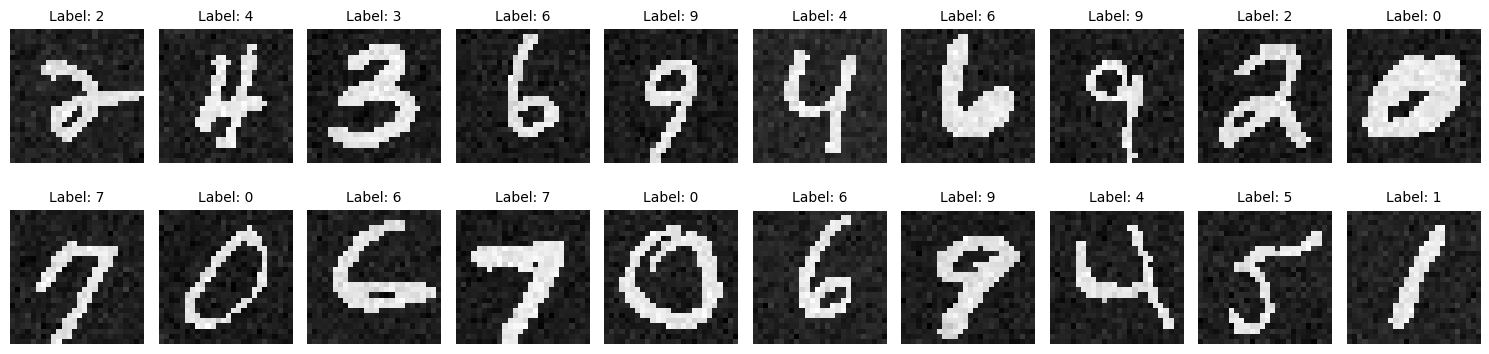

torch.Size([1000, 1, 26, 26])

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(15, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(train_in[i].cpu().squeeze(), cmap='gray')
    ax.set_title(f"Label: {train_lab[i].item()}", fontsize=10)
    ax.axis('off')
plt.tight_layout()
plt.show()
train_in.shape

## Custom Neural Network

In [183]:
torch.backends.cudnn.benchmark = True

def tensor_stats(tensor, name="Tensor"):
    tensor = tensor.to(device)
    mean_magnitude = tensor.abs().mean().item()
    print(f"{name} - Mean Magnitude: {mean_magnitude:.2e}, Max: {tensor.max().item():.2e}, Min: {tensor.min().item():.2e}")

import torch
import torch.nn as nn

class SoftBinaryRecurrentForwardNetwork(nn.Module):
    def __init__(self, scaling, G_ON, G_OFF, V_INV, R_INV, V_1, V_0, zeta, initial_factor, crossbar=(64,64),
                 input_size=676, encoding_size=3, output_size=10, data_in=48, bin_active=True,
                 monitor_volts=False, monitor_grads=True, monitor_latents=False, dropout=0.01, alpha = 0.9,
                 int_lr=0.01, int_norm=True, temperature_1 = 500, temperature_2 = 10000,monitor_annealing=False):
        super().__init__()

        self.w = nn.Parameter(initial_factor * torch.empty(crossbar, device=device))
        nn.init.xavier_uniform_(self.w)
        self.w.data = (initial_factor*(self.w.data))

        self.G_ON, self.G_OFF = torch.tensor(G_ON, device=device)*scaling, torch.tensor(G_OFF, device=device)*scaling
        self.V_INV, self.R_INV = torch.tensor(V_INV, device=device), torch.tensor(R_INV, device=device)
        self.V_1, self.V_0 = torch.tensor(V_1, device=device), torch.tensor(V_0, device=device)

        self.crossbar_in, self.crossbar_out = crossbar
        self.encoding, self.data_in, self.output_size = encoding_size, data_in, output_size
        self.r_passes = input_size // data_in

        self.first_bias = (crossbar[0] - data_in) % encoding_size
        self.final_bias = (crossbar[0] - self.encoding * self.r_passes - self.extra_final) % (self.extra_final + self.encoding)

        self.feed_repeats = (crossbar[0] - data_in)//encoding_size
        self.final_repeats = (crossbar[0] - self.encoding * self.r_passes - self.extra_final)//(self.extra_final + self.encoding)

        self.zeta, self.int_lr = torch.tensor(zeta, device=device), torch.tensor(int_lr, device=device)
        self.bin_active, self.int_norm = bin_active, int_norm
        self.monitor_volts, self.monitor_grads, self.monitor_latents = monitor_volts, monitor_grads, monitor_latents
        self.monitor_annealing = monitor_annealing
        self.dropout = nn.Dropout(p=dropout)

        self.temperature_1 = temperature_1
        self.temperature_2 = temperature_2
        self.device = device

        self.velocity = torch.zeros(crossbar, device = device)
        self.alpha = alpha

    def INV_AMP(self, x, R_INV):
        return -self.V_INV * torch.tanh(R_INV * x / self.V_INV)

    def SOFT_BIN(self, x):
        if self.bin_active: return ((self.G_ON - self.G_OFF) * torch.sigmoid(x * self.zeta) + self.G_OFF)
        else: return self.G_ON * x * self.zeta * 0.4

    def PREPROCESS(self, img):
        return (self.V_1 - self.V_0) * img.to(device) + self.V_0

    def ANNEALER(self):
        prob = torch.exp(torch.tensor(-1.0, device=self.device) / self.temperature_1)
        prob = torch.clamp(prob, min=1e-3, max=1)

        rand_vals = torch.rand((64, 64), device=self.device)
        annealed_mask = torch.where(rand_vals < prob, -1, torch.where(rand_vals < 2 * prob, 0, 1))

        return annealed_mask

    def forward(self, img):
        # Preprocessing: Two States of input (V_ON and V_OFF)
        img = self.PREPROCESS(img.view(img.size(0), -1))
        bias = self.PREPROCESS(((-1) ** torch.arange(self.first_bias, device=device)).repeat(img.shape[0], 1))
        bias2 = self.PREPROCESS(((-1) ** torch.arange(self.final_bias, device=device)).repeat(img.shape[0], 1))

        # RRAM Soft Binarization
        g = self.SOFT_BIN(self.w)
        if self.monitor_latents: tensor_stats(self.w, "Latent Weights:")

        # Recurrent Encoding Layer
        out1size = self.crossbar_out - self.output_size
        feedback = torch.zeros((img.shape[0], self.encoding*self.feed_repeats), device=device)
        out1 = torch.zeros((img.shape[0], out1size), device = device)

        for r_pass in range(self.r_passes):
            ind_s, ind_f = self.crossbar_out - (r_pass+1)*self.encoding, self.crossbar_out - (r_pass)*self.encoding
            ind_a, ind_b = out1size - (r_pass+1)*self.encoding, out1size - (r_pass)*self.encoding

            x = torch.cat((feedback, bias, img[:, r_pass * self.data_in:(r_pass + 1) * self.data_in]), dim=1)
            x = F.linear(x, g[ind_s:ind_f, : ], bias=None)

            out1[:, ind_a:ind_b] = self.INV_AMP(x, self.R_INV)
            if self.monitor_volts: tensor_stats(feedback, f"Voltages in Recurrent Stage after pass {r_pass}")

            feedback = out1[:, ind_a:ind_b].repeat(1,self.feed_repeats)

        x = torch.cat((feedback, bias2, out1), dim = 1)
        x = self.dropout(x)

        # Feature Extraction layer
        
        
        # Classification Layer
        x = F.linear(x, g[:self.output_size, : ], bias=None)
        x = self.INV_AMP(x, self.R_INV)
        if self.monitor_volts: tensor_stats(x, f"Voltages after h_layer {h_pass}")

        return x

    def backprop(self, ext_lr):
        with torch.no_grad():
            if self.w.grad is not None:
                grad = self.w.grad.to(device)
                for i in range(grad.shape[0]):
                    if self.int_norm:
                        grad[i] = self.int_lr * grad[i] / (torch.norm(grad[i]) + 1e-20)
                    grad[i] = grad[i]
                grad = grad + self.alpha*self.velocity
                if self.monitor_grads: tensor_stats(ext_lr*grad, "Gradients")
                self.w -= grad * ext_lr
                self.velocity = grad
                self.w.grad.zero_()

    def anneal(self, inputs, labels, decay1, decay2):
        with torch.no_grad():
            outputs = self.forward(inputs)
            old_loss = criterion(outputs, labels).item() * inputs.size(0)
            old_w = self.w.data.clone()

            self.w.data = self.w.data * self.ANNEALER()
            outputs = self.forward(inputs)
            new_loss = criterion(outputs, labels).item() * inputs.size(0)

            acceptance_prob = torch.exp(torch.tensor(-(new_loss - old_loss) / self.temperature_2, device=self.device))
            if self.monitor_annealing: print("Old & New Losses", old_loss, new_loss,"Probab:", acceptance_prob)
            if new_loss < old_loss or torch.rand(1, device=self.device) < acceptance_prob:
                if self.monitor_annealing: print("Annealed weights accepted")
            else:
                self.w.data = old_w

            self.temperature_1 *= decay1
            self.temperature_2 *= decay2

## Model Parameters

In [200]:
params_RRAM = {
    "scaling": 3,
    "G_ON": 6e-5,
    "G_OFF": 2.88e-6,
    "V_INV": 1.2,
    "R_INV": 2400.0,
    "V_1": 0.1,
    "V_0": -0.1,
    "zeta": 10.0,
    "initial_factor": 0.01,
    "crossbar": (64, 64),
    "input_size": 676,
    "encoding_size": 4,
    "output_size": 10,
    "data_in": 52,
    "bin_active": True,
    "monitor_volts": False,
    "monitor_grads": False,
    "monitor_latents": False,
    "dropout": 0.05,
    "int_lr": 0.01,
    "int_norm": True,
    "ext_lr": 200,
    "epochs": 1000,
    "temperature_1": 0.3,
    "temperature_2": 25,
    "monitor_annealing": False,
    "decay1" : 0.99,
    "decay2" : 0.95,
    "anneal_per_epoch" : False,
    "anneal_per_batch" : True,
    "early_stop_wait": 21,
    "fine_tune_wait": 7,
    "temperature_wait": 3,
    "T_boost": 500,
    "alpha": 0.2
}

training_params = ["noise_std", "batch_size", "lr", "epochs","ext_lr", "decay1", "decay2", "anneal_per_epoch", 
                   "anneal_per_batch", "fine_tune_wait", "early_stop_wait","temperature_wait", "T_boost"]
model_params = {k: v for k, v in params_RRAM.items() if k not in training_params}

In [201]:
model_RRAM = SoftBinaryRecurrentForwardNetwork(**model_params).to(device)

In [202]:
print("Number of Bits Flipped :", 64*64*torch.exp(torch.tensor(-1.0, device=device) / model_RRAM.temperature_1))
print("Batchwise Acceptance", torch.exp(torch.tensor(-(10) / model_RRAM.temperature_2, device=device)))
print("Epochwise Acceptance", torch.exp(torch.tensor(-(100) / model_RRAM.temperature_2, device=device)))

Number of Bits Flipped : tensor(146.1207, device='cuda:0')
Batchwise Acceptance tensor(0.6703, device='cuda:0')
Epochwise Acceptance tensor(0.0183, device='cuda:0')


## Training:

### Training to a subset of Dataset First

This is just to see if the model is backpropagating before putting in into the full training

In [203]:
# Training parameters
lr = params_RRAM["ext_lr"] / 25  # Initial learning rate
num_epochs = 50

criterion = nn.CrossEntropyLoss().to(device)

for epoch in range(num_epochs):
    if epoch == 1:
        lr *= 5
    elif epoch == 2:
        lr *= 5

    model_RRAM.train()
    outputs = model_RRAM(train_in)
    loss = criterion(outputs, train_lab)
    loss.backward()
    model_RRAM.backprop(lr)
    model_RRAM.anneal(train_in, train_lab,0.5, 0.5)

    _, train_preds = torch.max(outputs, dim=1)
    train_accuracy = (train_preds == train_lab).float().mean().item() * 100

    print(f"Epoch {epoch + 1}, LR: {lr:.4f}, Train Loss: {loss.item():.4f}, "
          f"Train Accuracy: {train_accuracy:.2f}%, Temperatures:({model_RRAM.temperature_1:.2f}, {model_RRAM.temperature_2:.2f})")

    if epoch % 50 == 0 and epoch != 0:
        lr /= 2

model_RRAM = SoftBinaryRecurrentForwardNetwork(**model_params).to(device)

Epoch 1, LR: 8.0000, Train Loss: 2.3026, Train Accuracy: 9.90%, Temperatures:(0.15, 12.50)
Epoch 2, LR: 40.0000, Train Loss: 2.3026, Train Accuracy: 9.90%, Temperatures:(0.07, 6.25)
Epoch 3, LR: 200.0000, Train Loss: 2.3136, Train Accuracy: 12.10%, Temperatures:(0.04, 3.12)
Epoch 4, LR: 200.0000, Train Loss: 2.7826, Train Accuracy: 12.00%, Temperatures:(0.02, 1.56)
Epoch 5, LR: 200.0000, Train Loss: 2.5777, Train Accuracy: 10.70%, Temperatures:(0.01, 0.78)
Epoch 6, LR: 200.0000, Train Loss: 2.3406, Train Accuracy: 12.60%, Temperatures:(0.00, 0.39)
Epoch 7, LR: 200.0000, Train Loss: 2.1992, Train Accuracy: 20.60%, Temperatures:(0.00, 0.20)
Epoch 8, LR: 200.0000, Train Loss: 2.0827, Train Accuracy: 19.10%, Temperatures:(0.00, 0.10)
Epoch 9, LR: 200.0000, Train Loss: 1.9667, Train Accuracy: 25.30%, Temperatures:(0.00, 0.05)
Epoch 10, LR: 200.0000, Train Loss: 1.8628, Train Accuracy: 27.00%, Temperatures:(0.00, 0.02)
Epoch 11, LR: 200.0000, Train Loss: 1.7858, Train Accuracy: 34.10%, Tempe

### Loading Past Best Model

In [206]:
try:
    # Load best validation loss model
    with open("Best_Val_Loss.txt", 'r') as f:
        global_best_val_loss = float(f.read())
    with open("Best_Params_Loss.txt", 'r') as f:
        params_best_loss = ast.literal_eval(f.read())

    model_best_loss = SoftBinaryRecurrentForwardNetwork(**model_params).to(device)

    print("\n Best Validation Loss:", global_best_val_loss)
    print("\n Parameters for Best Loss Model:", params_best_loss)

    checkpoint_loss = torch.load("Best_model_loss.pth")
    model_best_loss.load_state_dict(checkpoint_loss)

except Exception as e:
    print("Error loading best loss model:", e)
    global_best_val_loss = float('inf')
    print("No Saved Model for Best Loss")

try:
    # Load best validation accuracy model
    with open("Best_Val_Acc.txt", 'r') as f:
        global_best_val_acc = float(f.read())
    with open("Best_Params_Acc.txt", 'r') as f:
        params_best_acc = ast.literal_eval(f.read())

    model_best_acc = SoftBinaryRecurrentForwardNetwork(**model_params).to(device)

    print("\n Best Validation Accuracy:", global_best_val_acc)
    print("\n Parameters for Best Accuracy Model:", params_best_acc)

    checkpoint_acc = torch.load("Best_model_acc.pth")
    model_best_acc.load_state_dict(checkpoint_acc)

except Exception as e:
    print("Error loading best accuracy model:", e)
    global_best_val_acc = 0.0
    print("No Saved Model for Best Accuracy")



 Best Validation Loss: 1.306089

 Parameters for Best Loss Model: {'scaling': 3, 'G_ON': 6e-05, 'G_OFF': 2.88e-06, 'V_INV': 1.2, 'R_INV': 2400.0, 'V_1': 0.1, 'V_0': -0.1, 'zeta': 10.0, 'initial_factor': 0.01, 'crossbar': (64, 64), 'input_size': 676, 'encoding_size': 4, 'output_size': 10, 'data_in': 52, 'bin_active': True, 'monitor_volts': False, 'monitor_grads': False, 'monitor_latents': False, 'dropout': 0.05, 'int_lr': 0.01, 'int_norm': True, 'ext_lr': 200, 'epochs': 1000, 'temperature_1': 0.4, 'temperature_2': 25, 'monitor_annealing': False, 'decay1': 0.99, 'decay2': 0.95, 'anneal_per_epoch': False, 'anneal_per_batch': True, 'early_stop_wait': 21, 'fine_tune_wait': 7, 'temperature_wait': 3, 'T_boost': 500}

 Best Validation Accuracy: 71.01

 Parameters for Best Accuracy Model: {'scaling': 3, 'G_ON': 6e-05, 'G_OFF': 2.88e-06, 'V_INV': 1.2, 'R_INV': 2400.0, 'V_1': 0.1, 'V_0': -0.1, 'zeta': 10.0, 'initial_factor': 0.01, 'crossbar': (64, 64), 'input_size': 676, 'encoding_size': 4, 'out

In [207]:
history_RRAM = {
    "train_loss": [],
    "train_accuracy": [],
    "val_loss": [],
    "val_accuracy": []
}

### Complete Training

In [208]:
lr = params_RRAM["ext_lr"] / 25
num_epochs = params_RRAM["epochs"]
patience_stop, patience_lr, patience_T = params_RRAM["early_stop_wait"], params_RRAM["fine_tune_wait"], params_RRAM["temperature_wait"]
wait_lr, wait_stop = 0, 0
cur_best_val_loss, cur_best_val_acc = float('inf'), 0
temp_boosted = False

for epoch in range(num_epochs):
    if epoch == 0:
        lr = lr
    elif epoch <= 2:
        lr *= 5

    model_RRAM.train().to(device)
    train_loss, train_correct, total_samples = 0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_RRAM(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        model_RRAM.backprop(lr)

        train_loss += loss.item() * inputs.size(0)
        train_correct += (outputs.argmax(1) == labels).sum().item()
        total_samples += inputs.size(0)
        
        if params_RRAM["anneal_per_batch"]:
            model_RRAM.anneal(inputs, labels, params_RRAM["decay1"], params_RRAM["decay2"])

    train_loss /= total_samples
    train_accuracy = 100 * train_correct / total_samples

    model_RRAM.eval()
    val_loss, val_correct, total_test_samples = 0, 0, 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_RRAM(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()
            total_test_samples += inputs.size(0)

    val_loss /= total_test_samples
    val_accuracy = 100 * val_correct / total_test_samples

    history_RRAM["train_loss"].append(train_loss)
    history_RRAM["train_accuracy"].append(train_accuracy)
    history_RRAM["val_loss"].append(val_loss)
    history_RRAM["val_accuracy"].append(val_accuracy)

    print(f"Epoch {epoch + 1}, LR: {lr:.4f}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%, Temperatures: ({model_RRAM.temperature_1:.2f}, {model_RRAM.temperature_2:.2f})")

    if val_loss < global_best_val_loss:
        global_best_val_loss = val_loss
        torch.save(model_RRAM.state_dict(), "Best_model_loss.pth")
        with open("Best_Val_Loss.txt", "w") as f:
            f.write(f"{val_loss:.6f}")
        with open("Best_Params_Loss.txt", "w") as f:
            f.write(f"{params_RRAM}")
        print(f"Model saved with best validation loss: {val_loss:.6f}")

    if val_accuracy > global_best_val_acc:
        global_best_val_acc = val_accuracy
        torch.save(model_RRAM.state_dict(), "Best_model_acc.pth")
        with open("Best_Val_Acc.txt", "w") as f:
            f.write(f"{val_accuracy:.6f}")
        with open("Best_Params_Acc.txt", "w") as f:
            f.write(f"{params_RRAM}")
        print(f"Model saved with best validation accuracy: {val_accuracy:.6f}")

    if params_RRAM["anneal_per_epoch"]:
        model_RRAM.anneal(inputs, labels, params_RRAM["decay1"], params_RRAM["decay2"])

    if wait_lr >= patience_lr and epoch > 3:
        lr /= 5
        wait_lr = 0
        print(f"No improvement for {patience_lr} epochs. Reducing LR to {lr:.4f}")

    if wait_lr >= patience_T and not temp_boosted:
        model_RRAM.temperature_2 *= params_RRAM["T_boost"]
        temp_boosted = True
        print(f"Training plateau detected. Temporarily increasing temperature_2 to {model_RRAM.temperature_2:.2f}")

    if val_loss < cur_best_val_loss - 0.001 or val_accuracy > cur_best_val_acc + 0.1:
        if temp_boosted:
            model_RRAM.temperature_2 /= params_RRAM["T_boost"]
            temp_boosted = False
            print(f"Training improved. Restoring temperature_2 to {model_RRAM.temperature_2:.2f}")

        cur_best_val_loss = min(cur_best_val_loss, val_loss)
        cur_best_val_acc = max(cur_best_val_acc, val_accuracy)
        wait_stop = 0
        wait_lr = 0
    else:
        wait_stop += 1
        wait_lr += 1

    if wait_stop >= patience_stop and epoch > 6:
        print("Early stopping triggered.")
        break


Epoch 1, LR: 8.0000, Train Loss: 2.0119, Train Acc: 29.70%, Val Loss: 1.7075, Val Acc: 46.90%, Temperatures: (0.16, 1.15)
Epoch 2, LR: 40.0000, Train Loss: 1.5381, Train Acc: 56.91%, Val Loss: 1.4238, Val Acc: 62.74%, Temperatures: (0.09, 0.05)
Epoch 3, LR: 200.0000, Train Loss: 1.4480, Train Acc: 63.98%, Val Loss: 1.4174, Val Acc: 67.66%, Temperatures: (0.05, 0.00)
Epoch 4, LR: 200.0000, Train Loss: 1.4340, Train Acc: 64.81%, Val Loss: 1.3689, Val Acc: 68.42%, Temperatures: (0.03, 0.00)
Epoch 5, LR: 200.0000, Train Loss: 1.4118, Train Acc: 66.60%, Val Loss: 1.3784, Val Acc: 67.79%, Temperatures: (0.01, 0.00)
Epoch 6, LR: 200.0000, Train Loss: 1.4288, Train Acc: 65.60%, Val Loss: 1.4040, Val Acc: 67.33%, Temperatures: (0.01, 0.00)
Epoch 7, LR: 200.0000, Train Loss: 1.4413, Train Acc: 64.70%, Val Loss: 1.4494, Val Acc: 62.46%, Temperatures: (0.00, 0.00)
Epoch 8, LR: 200.0000, Train Loss: 1.4651, Train Acc: 62.97%, Val Loss: 1.4200, Val Acc: 63.61%, Temperatures: (0.00, 0.00)
Training pl

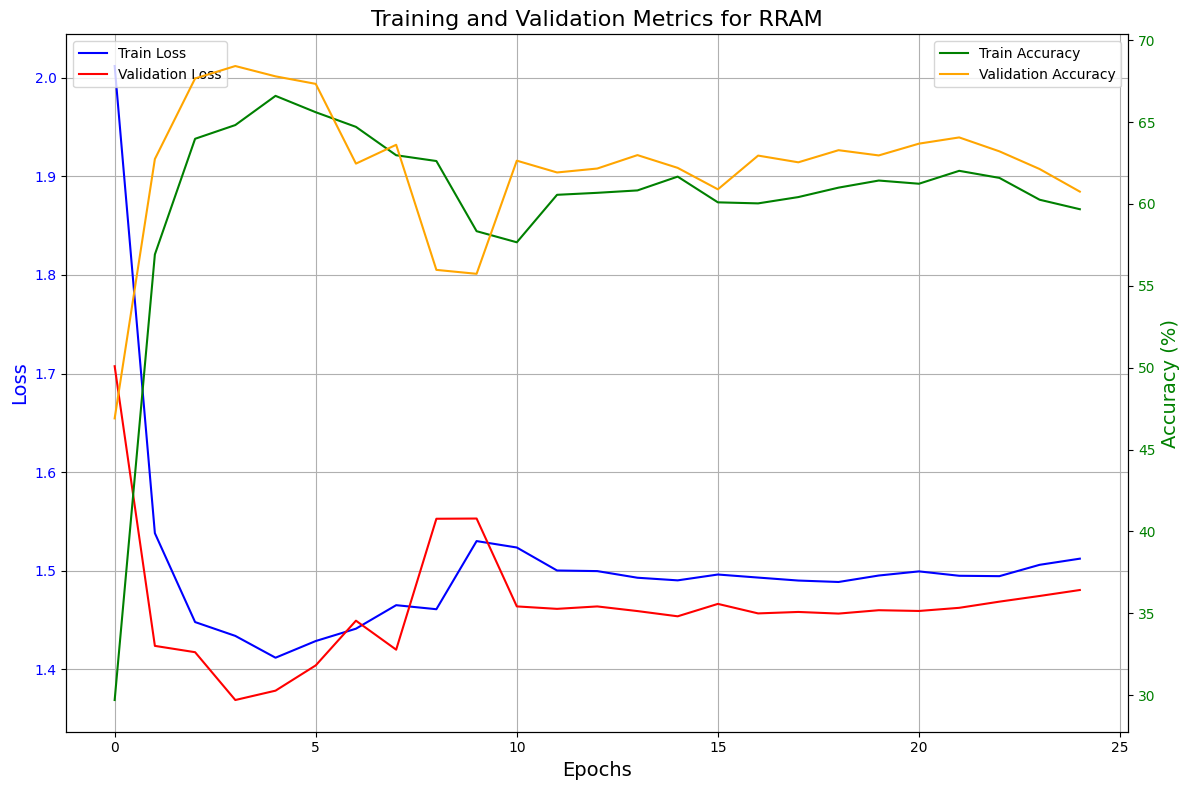

In [209]:
plot_history(history_RRAM, num_epochs, "RRAM")

In [ ]:
# model_RRAM.load_state_dict(model_best_acc.state_dict())

## Testing

### Current Model

In [ ]:
print(0 + (model_RRAM.w > 0))

In [ ]:
cm = test(model_RRAM, val_inputs, val_labels, class_names = ["A", "T", "V", "X"])

## Best Model:

In [ ]:
0+1*(model_best.w>0)

In [ ]:
cm = test(model_best, val_inputs, val_labels, class_names = ["A", "T", "V", "X"])

## PWL Generation

Let's assume that we will program the two crossbars with seperate PWLs. That is, during programming, we will cut the Inverting Amplifier stages with a pass transistor and connect the programming lines with a pass transistor. First array has 16 Top PWLs and 8 Bottom PWLs. Second array has 8 Top PWLs and 4 Bottom PWLs. And then once the programming switch is toggled to inference mode, only the 16 Top PWLs are to be changed. Let's also generate a PWL for that too.

In the code below, we will first maintain tuples for each PWL that holds what the voltage should be. And then we will write a function that will take there and space pulses of the given voltage that are 100us apart from other and have an ON duration of 100us

In [ ]:
WL_FC1 = [list() for i in range(16)]
BL_FC1 = [list() for i in range(8)]
WL_FC2 = [list() for i in range(8)]
BL_FC2 = [list() for i in range(4)]
Mode = []
Mode_B = []

V_WRITE = 1.5
V_READ = 0.1
V_mode = 1.2

#### Fully Connected Weights 1

In [ ]:
target = (model_RRAM_best.w1>0).int()
target

In [ ]:
for ind_i, i in enumerate(target):
    for ind_j, j in enumerate(i):
        if j==1: WL_FC1[ind_j].append(V_WRITE)
        else: WL_FC1[ind_j].append(V_WRITE/3)
    for ind_k in range(len(target)):
        if ind_k==ind_i: BL_FC1[ind_i].append(0)
        else: BL_FC1[ind_k].append(2*V_WRITE/3)

#### Fully Connected Weights 2

In [ ]:
target = (model_RRAM_best.w2>0).int()
target

In [ ]:
for ind_i, i in enumerate(target):
    for ind_j, j in enumerate(i):
        if j==1: WL_FC2[ind_j].append(V_WRITE)
        else: WL_FC2[ind_j].append(V_WRITE/3)
    for ind_k in range(len(target)):
        if ind_k==ind_i: BL_FC2[ind_i].append(0)
        else: BL_FC2[ind_k].append(2*V_WRITE/3)

#### Filling Out Programming Mode

In [ ]:
WL_FC1 = [i + [0,0] for i in WL_FC1]
BL_FC1 = [i + [0,0] for i in BL_FC1]
while(len(WL_FC2[0]) < len(WL_FC1[0])):
    WL_FC2 = [i + [0,] for i in WL_FC2]
    BL_FC2 = [i + [0,] for i in BL_FC2]
Mode.extend([V_mode]*(len(WL_FC1[0])-1) + [-V_mode])
Mode_B.extend([-V_mode]*(len(WL_FC1[0])-1) + [V_mode])

In [ ]:
print(WL_FC1[0])
print(BL_FC1[0])
print(WL_FC2[0])
print(BL_FC2[0])
print(Mode)
print(Mode_B)
print(len(WL_FC1[0]), len(BL_FC1[0]), len(WL_FC2[0]), len(BL_FC2[0]), len(Mode), len(Mode_B))

### Inference: Loading the Testing Set

In [ ]:
val_inputs[0]

In [ ]:
V_1 = 0.1
V_0 = -0.1
include_testing = True
include_every = 4

In [ ]:
if include_testing:
    for i in val_inputs[::include_every]:
        i = i.flatten()
        for ind, j in enumerate(i):
            WL_FC1[ind].append(V_1 if j==1 else V_0)
        BL_FC1 = [i + [0,] for i in BL_FC1]
        WL_FC2 = [i + [0,] for i in WL_FC2]
        BL_FC2 = [i + [0,] for i in BL_FC2]
        Mode = Mode + [-V_mode,]
        Mode_B = Mode_B + [V_mode,]

### PWL Convertion

In [ ]:
def pwl(l):
    t = 0
    res = "pwl(time, 0us, 0V"
    for i in l:
        res += f", {t+5}us, {i:.2f}V, {t+100}us, {i:.2f}V, {t+105}us, 0V, {t+200}us, 0V"
        t+=200
    res += ")"
    return res

In [ ]:
pwl_data = []

for ind, i in enumerate(WL_FC1):
    pwl_data.append({"Signal": f"WL_FC1_{ind}", "Index": ind, "PWL": pwl(i)})
for ind, i in enumerate(BL_FC1):
    pwl_data.append({"Signal": f"BL_FC1_{ind}", "Index": ind, "PWL": pwl(i)})
for ind, i in enumerate(WL_FC2):
    pwl_data.append({"Signal": f"WL_FC2_{ind}", "Index": ind, "PWL": pwl(i)})
for ind, i in enumerate(BL_FC2):
    pwl_data.append({"Signal": f"BL_FC2_{ind}", "Index": ind, "PWL": pwl(i)})
pwl_data.append({"Signal": "Mode", "Index": "", "PWL": pwl(Mode)})
pwl_data.append({"Signal": "Mode_b", "Index": "", "PWL": pwl(Mode_B)})

pwl_data = pd.DataFrame(pwl_data)
pwl_data.to_csv("pwl_data.csv", index=False)
pwl_data.head()

#### Testing Accuracy on 160 Images
ADS isn't allowing PWLs longer than 160 Images, so let's check software accuracy for the same too

In [ ]:
test(model_RRAM_best, val_inputs[::4], val_labels[::4])

In [ ]:
test(model_RRAM_best, train_inputs, train_labels)

## Simulation Data from ADS

In [ ]:
simu = pd.read_csv("Testing_160_Images.csv")
simu

In [ ]:
def remove_units(value):
    return float(value.replace('E', 'e').split('V')[0].replace('sec', ''))

simu['time'] = simu['time'].apply(remove_units)
for col in ['A', 'X', 'V', 'T']:
    simu[col] = simu[col].apply(remove_units)
simu

We just need one sample every 0.1ms samples of these starting from 2.050ms to 33.850ms

In [ ]:
t_stamps = np.arange(2.05e-3, 33.9e-3, 0.2e-3)
t_stamps.shape

In [ ]:
sampled = []
window = 0.02e-3

for t in t_stamps:
    filtered = simu[(simu['time'] >= t - window) & (simu['time'] <= t + window)]

    avg_A = filtered['A'].mean()
    avg_X = filtered['X'].mean()
    avg_V = filtered['V'].mean()
    avg_T = filtered['T'].mean()

    sampled.append({
        'Image Index': t,
        'A': avg_A,
        'X': avg_X,
        'V': avg_V,
        'T': avg_T
    })

sampled = pd.DataFrame(sampled)
sampled

In [ ]:
def get_max_column(row):
    return row[['A', 'X', 'V', 'T']].idxmax()
sampled['Predicted Class'] = sampled.apply(get_max_column, axis=1)
sampled.to_csv("Sampled_Results.csv", index=False)
sampled

In [ ]:
ground_truth = ['A']*40 + ['X']*40 + ['V']*40 + ['T']*40
correct_predictions = sampled['Predicted Class'] == ground_truth
accuracy = correct_predictions.sum() / len(ground_truth)
print(accuracy*100,end="%")

In [ ]:
plt.figure(figsize=(7, 3.5))

plt.scatter(sampled.index, sampled['A'], color='red', label='A_pred', s=30, marker='o')  # Red dots for A
plt.scatter(sampled.index, sampled['X'], color='blue', label='X_pred', s=30, marker='o')  # Blue dots for X
plt.scatter(sampled.index, sampled['T'], color='green', label='T_pred', s=30, marker='o')  # Green dots for T
plt.scatter(sampled.index, sampled['V'], color='orange', label='V_pred', s=30, marker='o')  # Orange dots for V

plt.xlabel('Image Index')
plt.ylabel('Predicted Voltages (V)')
plt.legend()

plt.axvline(x=40, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=80, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=120, color='gray', linestyle='--', linewidth=2)

plt.text(20, plt.ylim()[1]*(-0.8), 'A', fontsize=15, color='black', ha='center')
plt.text(60, plt.ylim()[1]*0.8, 'X', fontsize=15, color='black', ha='center')
plt.text(100, plt.ylim()[1]*0.8, 'V', fontsize=15, color='black', ha='center')
plt.text(140, plt.ylim()[1]*(-0.8), 'T', fontsize=15, color='black', ha='center')

plt.show()